# Environment

In [24]:
import fitbit

import pandas as pd
import numpy as np

from datetime import datetime
from fbprophet import Prophet

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

import math

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Acquisition

In [25]:
chunks = fitbit.get_fitbit(files=['2018-04-26_through_2018-05-26.csv',
                           '2018-05-27_through_2018-06-26.csv',
                           '2018-06-27_through_2018-07-27.csv',
                           '2018-07-28_through_2018-08-26.csv',
                           '2018-08-27_through_2018-09-26.csv',
                           '2018-09-27_through_2018-10-27.csv',
                           '2018-10-28_through_2018-11-27.csv',
                           '2018-11-28_through_2018-12-28.csv'])

chunks = fitbit.clean_fitbit(chunks, cols=['Date', 'Calories Burned', 'Steps',
                            'Distance', 'Floors', 'Minutes Sedentary',
                            'Minutes Lightly Active', 'Minutes Fairly Active',
                            'Minutes Very Active', 'Activity Calories'])

# Preparation

In [26]:
df = fitbit.prepare_fitbit(chunks, 8, 'Date')
df.sample(10)

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-06-08,"2,465","1,929",0.91,1.0,"1,361",79.0,0.0,0.0,389
2018-08-31,"4,415","15,415",7.46,17.0,744,211.0,8.0,104.0,"2,640"
2018-10-02,"3,162","8,702",4.10,9.0,872,141.0,11.0,34.0,"1,205"
2018-11-26,"3,364","10,563",5.64,20.0,587,210.0,10.0,42.0,"1,605"
2018-07-11,"3,553","6,997",3.30,7.0,701,214.0,21.0,14.0,"1,495"
2018-08-22,"3,811","8,678",4.09,5.0,845,200.0,13.0,48.0,"1,852"
2018-07-12,"3,750","7,520",3.55,1.0,576,294.0,0.0,0.0,"1,787"
2018-07-18,"3,509","7,504",3.54,4.0,754,222.0,20.0,3.0,"1,502"
2018-08-17,"4,610","16,482",7.77,11.0,608,198.0,9.0,125.0,"2,686"


In [27]:
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.0,0,0.0,0,0.0
Steps,0,0.0,0,0.0,0,0.0
Distance,0,0.0,0,0.0,0,0.0
Floors,0,0.0,0,0.0,0,0.0
Minutes Sedentary,0,0.0,0,0.0,0,0.0
Minutes Lightly Active,0,0.0,0,0.0,0,0.0
Minutes Fairly Active,0,0.0,0,0.0,0,0.0
Minutes Very Active,0,0.0,0,0.0,0,0.0
Activity Calories,0,0.0,0,0.0,0,0.0


In [28]:
df = fitbit.convert_to_float(df, 'Calories Burned', 'Steps', 'Minutes Sedentary', 'Activity Calories')

In [29]:
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.000000,0,0.0,0,0.0
Steps,0,0.000000,0,0.0,0,0.0
Distance,0,0.000000,0,0.0,0,0.0
Floors,0,0.000000,0,0.0,0,0.0
Minutes Sedentary,71,31.696429,0,0.0,0,0.0
Minutes Lightly Active,0,0.000000,0,0.0,0,0.0
Minutes Fairly Active,0,0.000000,0,0.0,0,0.0
Minutes Very Active,0,0.000000,0,0.0,0,0.0
Activity Calories,0,0.000000,0,0.0,0,0.0


In [30]:
# Impute NaNs with mean values
df = df.fillna(df.mean())
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.0,0,0.0,0,0.0
Steps,0,0.0,0,0.0,0,0.0
Distance,0,0.0,0,0.0,0,0.0
Floors,0,0.0,0,0.0,0,0.0
Minutes Sedentary,0,0.0,0,0.0,0,0.0
Minutes Lightly Active,0,0.0,0,0.0,0,0.0
Minutes Fairly Active,0,0.0,0,0.0,0,0.0
Minutes Very Active,0,0.0,0,0.0,0,0.0
Activity Calories,0,0.0,0,0.0,0,0.0


# Exploration

In [31]:
fitbit.summarize_data(df)

HEAD
            Calories Burned   Steps  Distance  Floors  Minutes Sedentary  \
Date                                                                       
2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0              702.0   
2018-04-29           2851.0  1639.0      0.77     0.0              891.0   
2018-04-30           2825.0  1323.0      0.62     0.0              880.0   

            Minutes Lightly Active  Minutes Fairly Active  \
Date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-04-28                   155.0                   22.0   
2018-04-29                   122.0                    0.0   
2018-04-30                   104.0                    0.0   

            Minutes Very Active  A

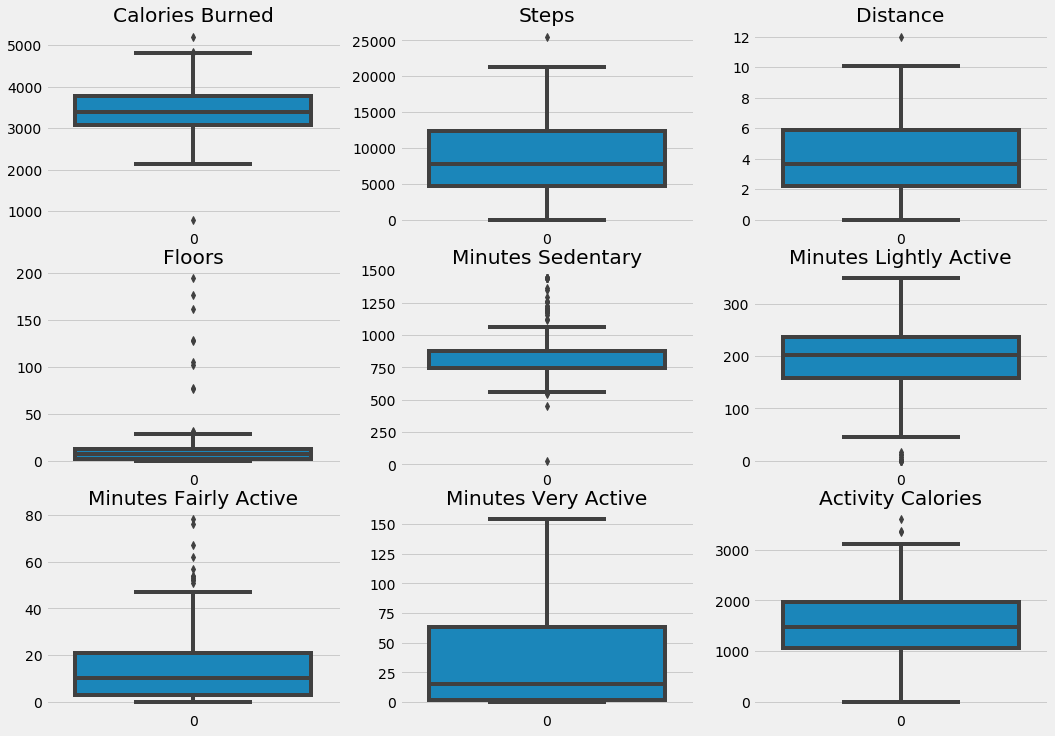

In [32]:
fitbit.plot_subs(df,
             df.select_dtypes(include='number').columns.values)

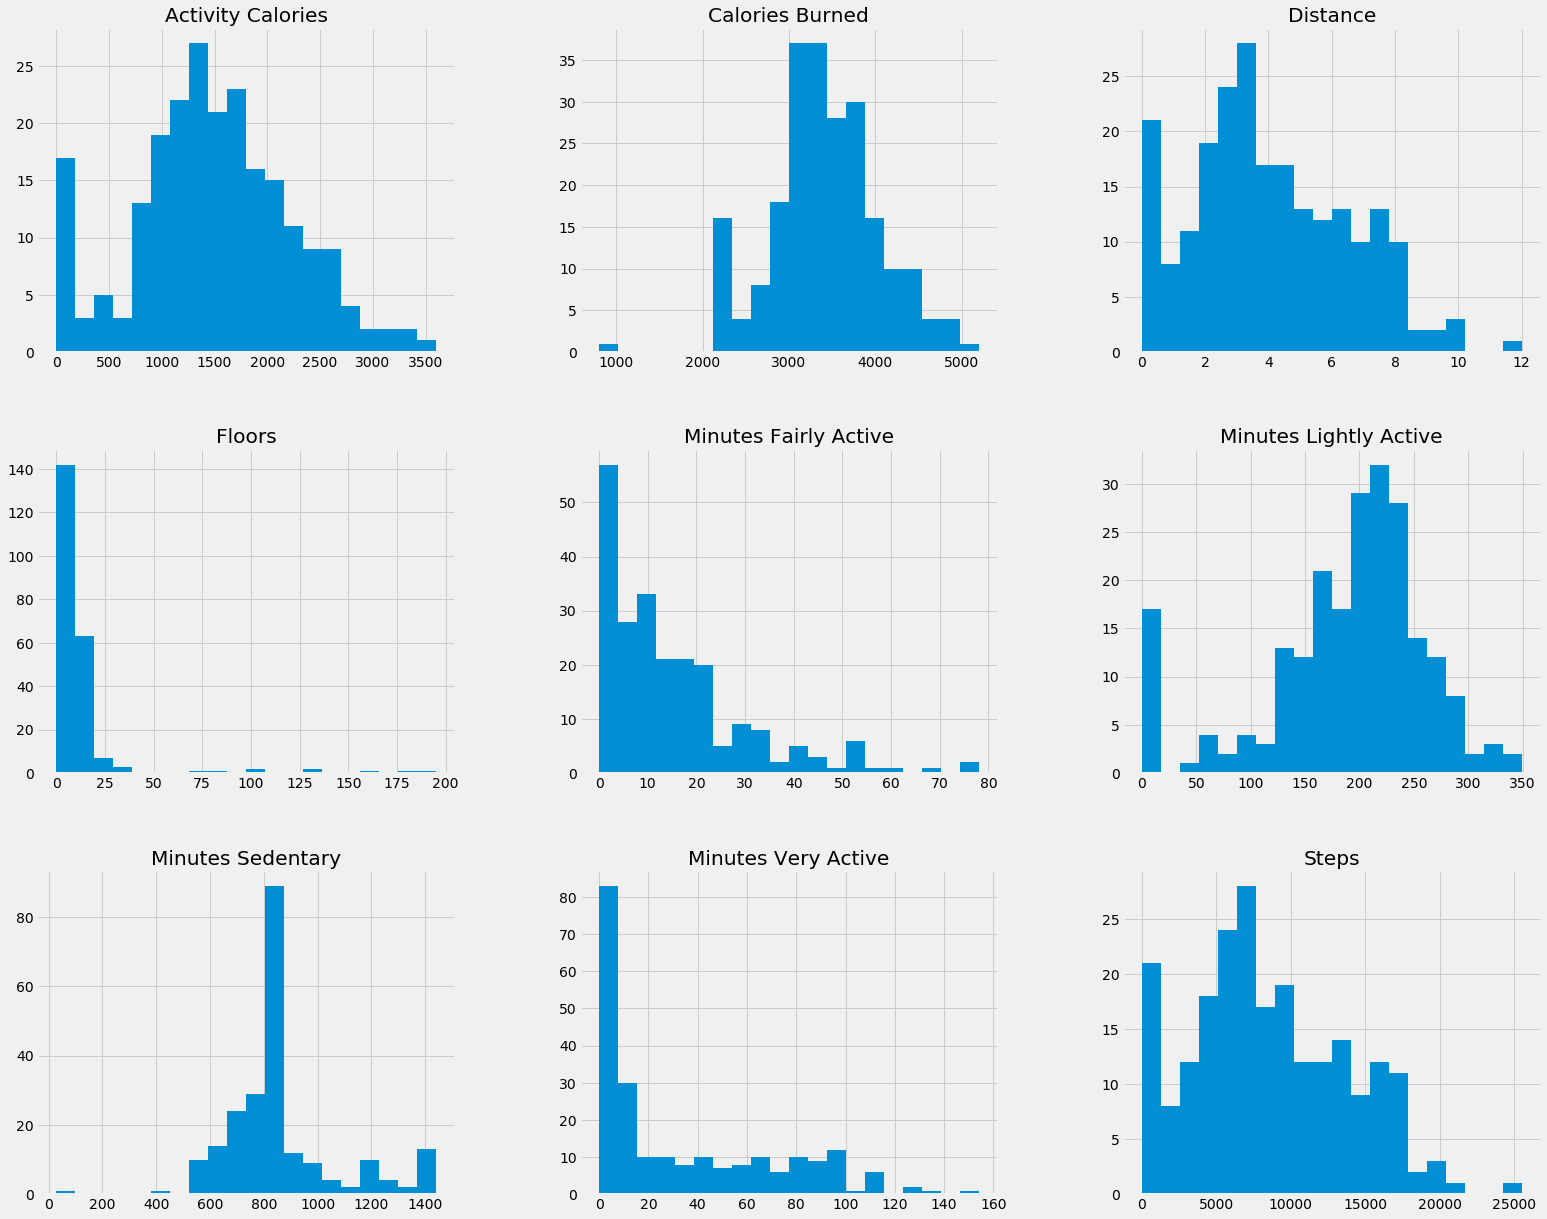

In [33]:
fitbit.plot_hist(df,20)

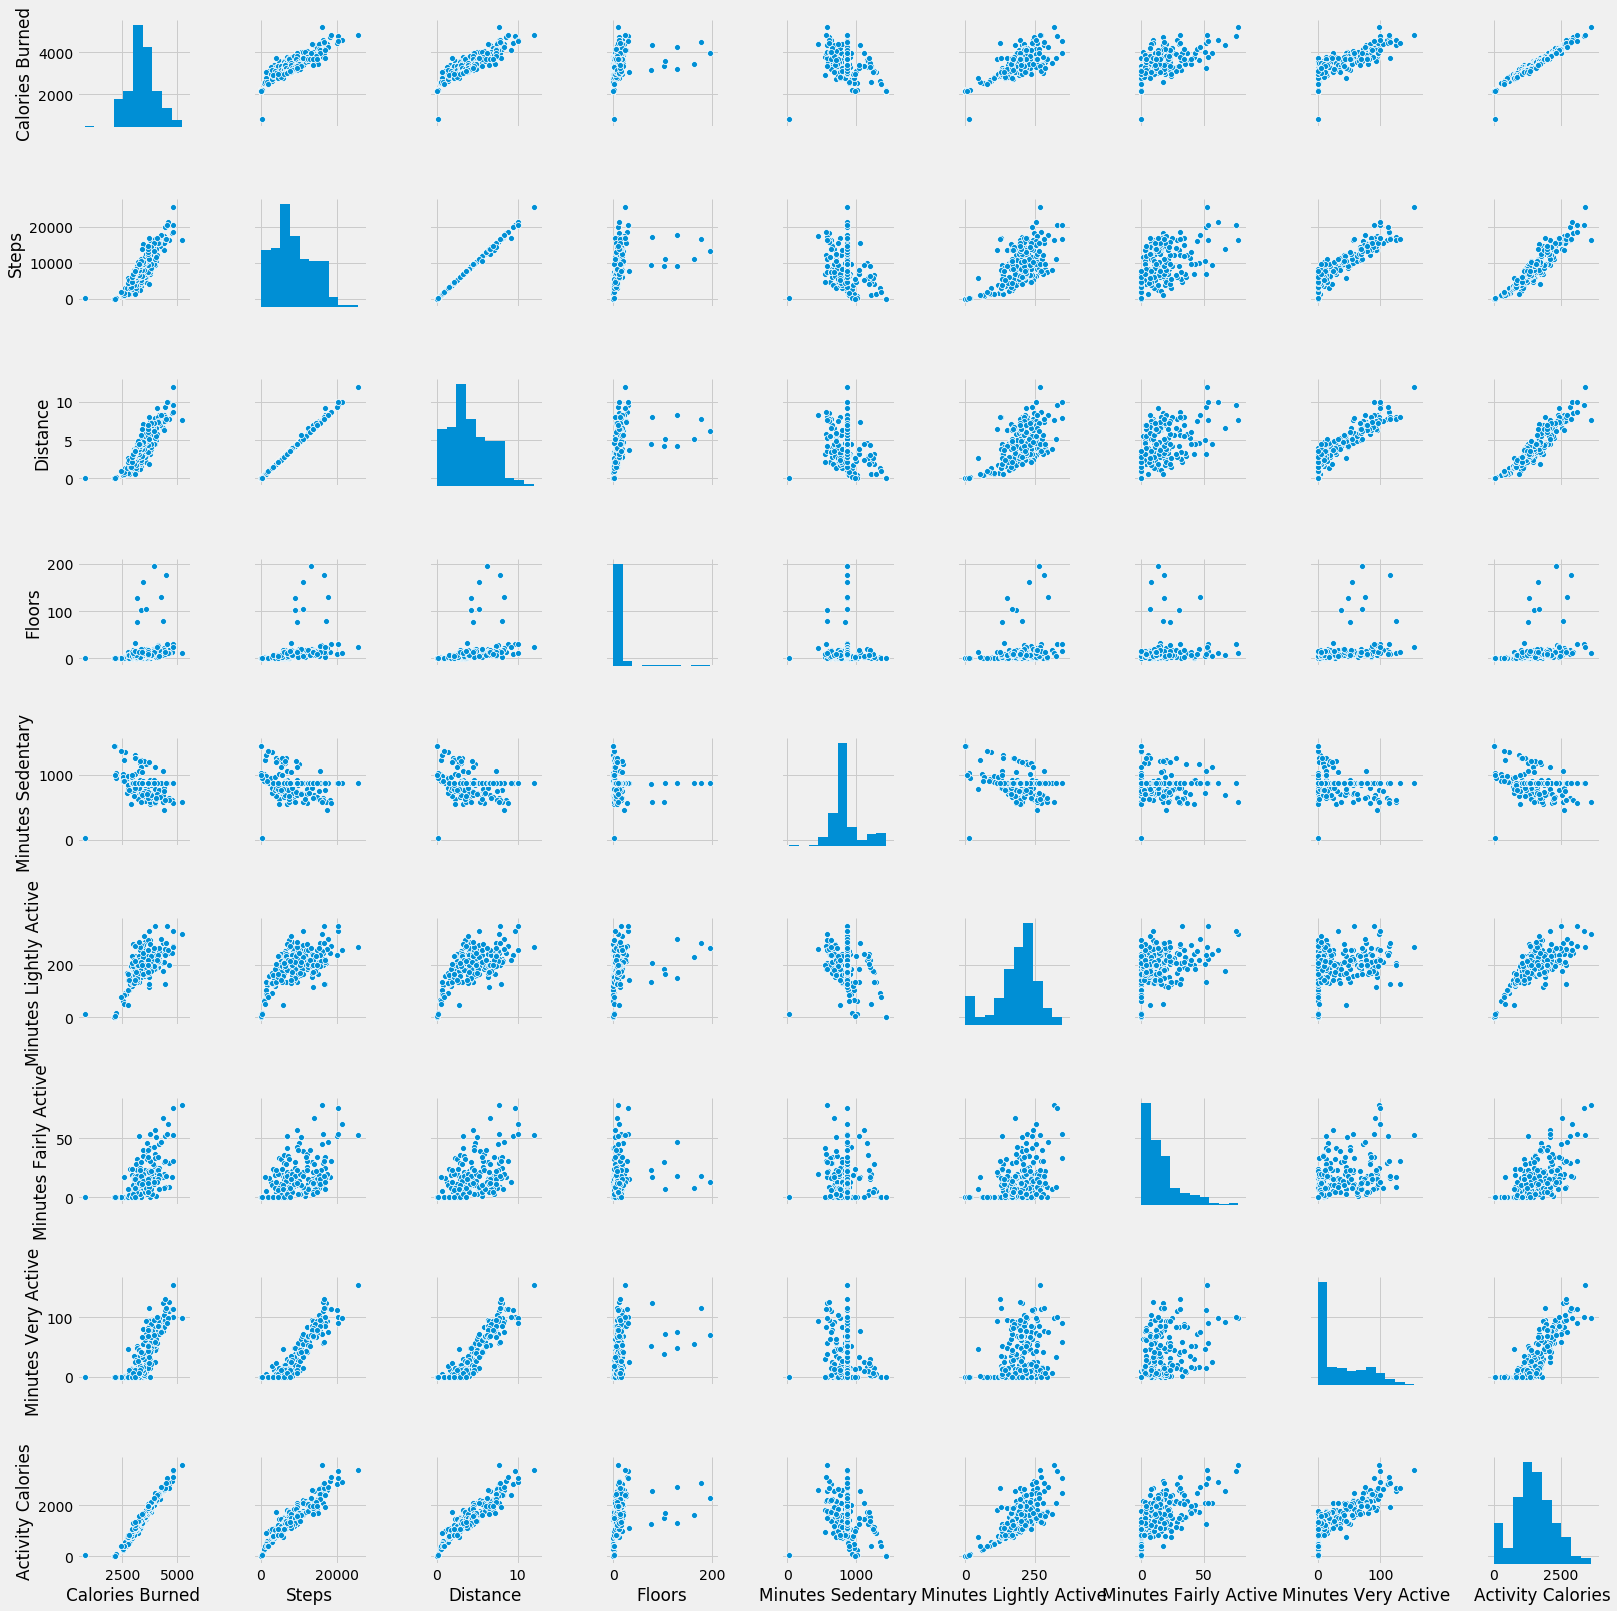

In [34]:
sns.pairplot(df)

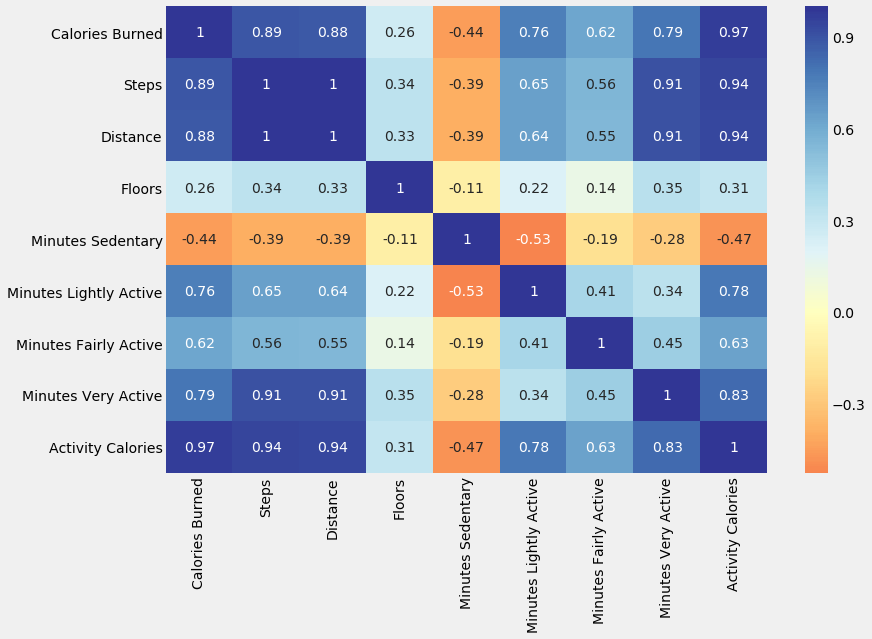

In [35]:
fitbit.plot_heat(df)

In [36]:
df.tail()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-12-02,3957.0,13257.0,6.23,195.0,875.169935,265.0,13.0,70.0,2305.0
2018-12-03,3660.0,12915.0,6.12,6.0,875.169935,219.0,40.0,51.0,1993.0
2018-12-04,3384.0,13763.0,6.49,13.0,875.169935,199.0,11.0,67.0,1663.0
2018-12-05,3670.0,13865.0,6.52,12.0,875.169935,200.0,12.0,69.0,1968.0
2018-12-06,3669.0,14774.0,6.96,9.0,875.169935,198.0,4.0,78.0,1962.0


In [37]:
df = df.reset_index()
fitbit.convert_to_datetime(df, 'Date')
df.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [38]:
df.head(10)

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0
5,2018-05-01,3292.0,2581.0,1.22,0.0,919.0,167.0,13.0,2.0,1068.0
6,2018-05-02,2660.0,1372.0,0.65,0.0,927.0,90.0,0.0,0.0,419.0
7,2018-05-03,3121.0,2232.0,1.05,0.0,876.0,157.0,16.0,0.0,1006.0
8,2018-05-04,2522.0,904.0,0.43,1.0,1012.0,61.0,0.0,0.0,269.0
9,2018-05-05,2551.0,833.0,0.39,0.0,969.0,68.0,0.0,0.0,326.0


In [39]:
df.columns

Index(['Date', 'Calories Burned', 'Steps', 'Distance', 'Floors',
       'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active',
       'Minutes Very Active', 'Activity Calories'],
      dtype='object')

In [40]:
ddf = df.copy()

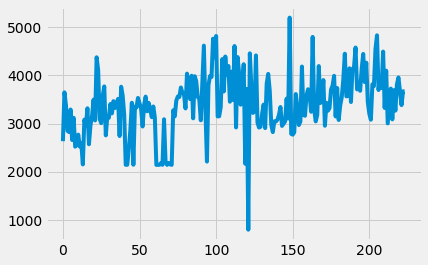

In [41]:
df['Calories Burned'].plot()

In [42]:
df.head()

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


### ---

In [44]:
df.head(10)

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0
5,2018-05-01,3292.0,2581.0,1.22,0.0,919.0,167.0,13.0,2.0,1068.0
6,2018-05-02,2660.0,1372.0,0.65,0.0,927.0,90.0,0.0,0.0,419.0
7,2018-05-03,3121.0,2232.0,1.05,0.0,876.0,157.0,16.0,0.0,1006.0
8,2018-05-04,2522.0,904.0,0.43,1.0,1012.0,61.0,0.0,0.0,269.0
9,2018-05-05,2551.0,833.0,0.39,0.0,969.0,68.0,0.0,0.0,326.0


In [47]:
df.rename(columns={'Calories Burned': 'calories_burned'}, inplace=True)

In [48]:
df.head(10)

,Date,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0
5,2018-05-01,3292.0,2581.0,1.22,0.0,919.0,167.0,13.0,2.0,1068.0
6,2018-05-02,2660.0,1372.0,0.65,0.0,927.0,90.0,0.0,0.0,419.0
7,2018-05-03,3121.0,2232.0,1.05,0.0,876.0,157.0,16.0,0.0,1006.0
8,2018-05-04,2522.0,904.0,0.43,1.0,1012.0,61.0,0.0,0.0,269.0
9,2018-05-05,2551.0,833.0,0.39,0.0,969.0,68.0,0.0,0.0,326.0


# Modeling

In [46]:
df_keras = df.copy()

## 1. Prophet

In [21]:
ddf['y'] = df['Calories Burned']
ddf['ds'] = pd.to_datetime(ddf['Date'])
ddf = ddf.groupby(['ds'])['y'].sum().reset_index()

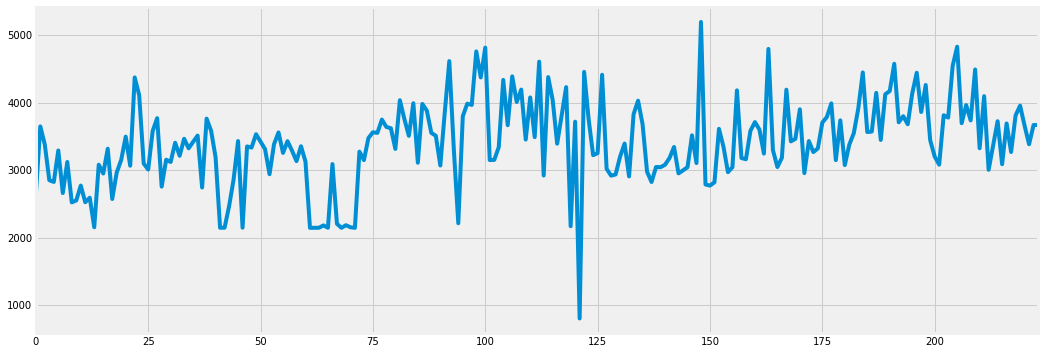

In [22]:
plt.figure(figsize=(16,6))
sns.tsplot(ddf.y)

In [23]:
ddf['cap'] = 6666
ddf['floor'] = 1000

m = Prophet(daily_seasonality=True, growth='logistic', changepoint_range=0.9)
m.fit(ddf)

future = m.make_future_dataframe(periods=60)
future['cap'] = 6666
future['floor'] = 1000
print(future.head())
print(future.tail())
print(ddf.tail())

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


          ds   cap  floor
0 2018-04-26  6666   1000
1 2018-04-27  6666   1000
2 2018-04-28  6666   1000
3 2018-04-29  6666   1000
4 2018-04-30  6666   1000
            ds   cap  floor
279 2019-01-31  6666   1000
280 2019-02-01  6666   1000
281 2019-02-02  6666   1000
282 2019-02-03  6666   1000
283 2019-02-04  6666   1000
            ds       y   cap  floor
219 2018-12-02  3957.0  6666   1000
220 2018-12-03  3660.0  6666   1000
221 2018-12-04  3384.0  6666   1000
222 2018-12-05  3670.0  6666   1000
223 2018-12-06  3669.0  6666   1000


In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
279,2019-01-31,4050.154070,3315.035918,4783.675515
280,2019-02-01,4102.682870,3354.048997,4808.000155
281,2019-02-02,4196.900875,3440.625501,4904.634478
282,2019-02-03,4190.165400,3455.475293,4925.165155
283,2019-02-04,3879.484437,3142.094673,4640.545135


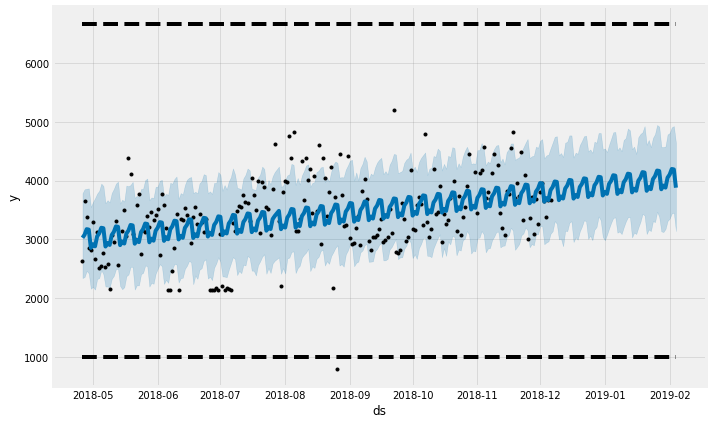

In [25]:
fig1 = m.plot(forecast)

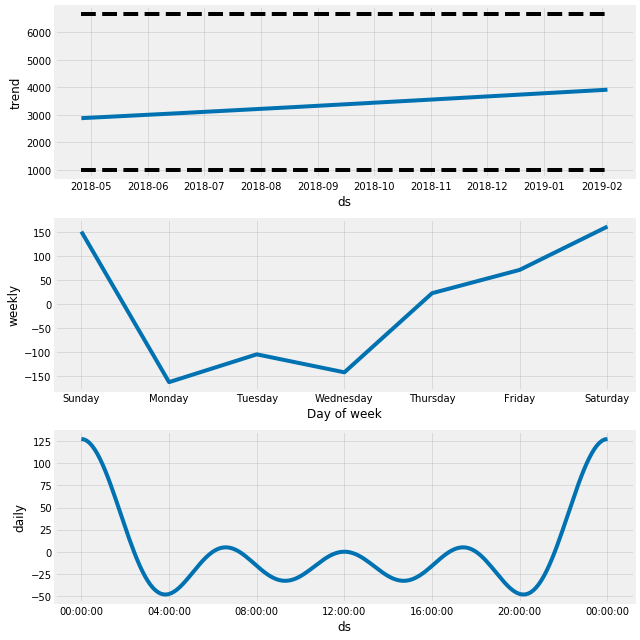

In [26]:
fig2 = m.plot_components(forecast)

In [27]:
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
ddf_cv = cross_validation(m, horizon='15 days')


ddf_p = performance_metrics(ddf_cv)
ddf_p.head(10)

INFO:fbprophet:Making 22 forecasts with cutoffs between 2018-06-16 12:00:00 and 2018-11-21 00:00:00


,horizon,mse,rmse,mae,mape,coverage
89,1 days 12:00:00,405031.246459,636.420652,521.755756,0.165399,0.78125
209,1 days 12:00:00,396610.168678,629.769933,510.682933,0.161470,0.78125
164,2 days 00:00:00,385833.568513,621.155028,493.156141,0.156813,0.78125
75,2 days 00:00:00,379367.701553,615.928325,488.530937,0.155809,0.81250
46,2 days 00:00:00,401609.839481,633.726944,507.647546,0.161146,0.78125
16,2 days 00:00:00,456364.711959,675.547713,531.998454,0.178012,0.75000
254,2 days 00:00:00,455599.206050,674.980893,531.070205,0.177853,0.75000
104,2 days 00:00:00,439740.512870,663.129333,510.134162,0.172896,0.75000
194,2 days 00:00:00,442102.165926,664.907637,511.607279,0.171170,0.75000
284,2 days 00:00:00,436893.683959,660.979337,506.292620,0.168150,0.75000


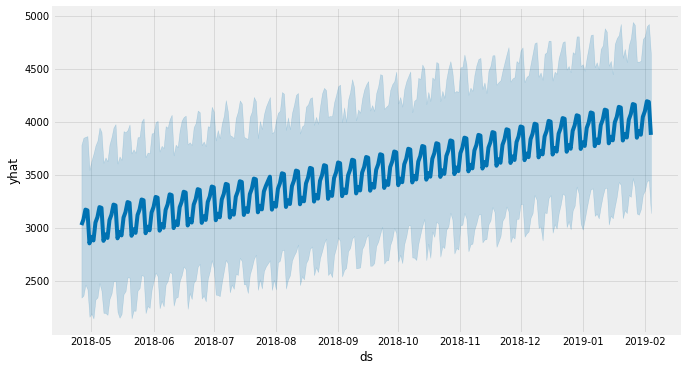

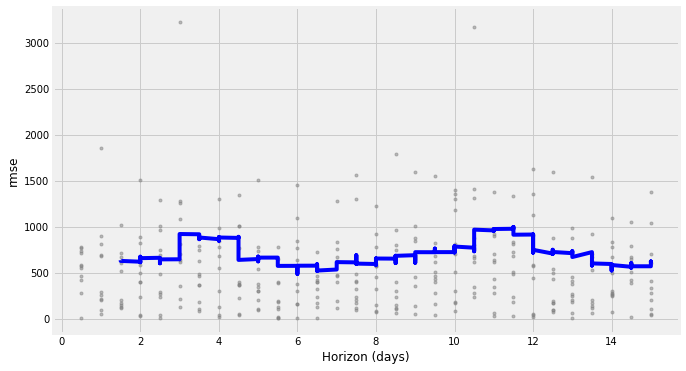

In [28]:
plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(ddf_cv, metric='rmse')

In [29]:
df.describe()

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
count,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000,224.000000
mean,3402.107143,8538.254464,4.047857,12.625000,875.169935,188.022321,14.901786,33.982143,1484.562500
std,633.836137,5267.425883,2.511816,25.897045,214.937696,75.270123,15.395509,37.241903,749.470549
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000
25%,3068.250000,4705.500000,2.217500,2.000000,748.750000,157.750000,3.000000,2.000000,1060.750000
50%,3389.000000,7789.000000,3.675000,7.000000,875.169935,202.000000,10.500000,15.000000,1477.000000
75%,3766.750000,12401.750000,5.905000,13.000000,875.377451,235.500000,21.000000,63.250000,1963.500000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000


In [30]:
df = df.set_index('Date')

In [31]:
df.head(10)

,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0
2018-05-01,3292.0,2581.0,1.22,0.0,919.0,167.0,13.0,2.0,1068.0
2018-05-02,2660.0,1372.0,0.65,0.0,927.0,90.0,0.0,0.0,419.0
2018-05-03,3121.0,2232.0,1.05,0.0,876.0,157.0,16.0,0.0,1006.0
2018-05-04,2522.0,904.0,0.43,1.0,1012.0,61.0,0.0,0.0,269.0


In [32]:
df.index = pd.to_datetime(df.index)

## 2. Simple Average

In [33]:
ts_data = df['Calories Burned'].resample('D').agg('sum')

In [34]:
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[0:train_size], ts_data[train_size:len(ts_data)]
print('Observations: %d' % (len(ts_data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 180
Testing Observations: 45


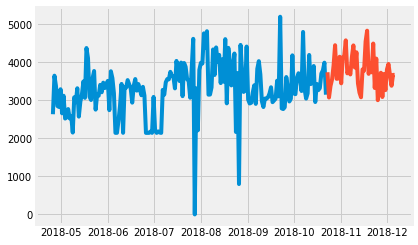

In [35]:
plt.plot(train)
plt.plot(test)
plt.show()

In [36]:
yhat = pd.DataFrame(dict(actual=test))

In [37]:
yhat['avg_forecast'] = train.mean()

In [38]:
yhat.head()

,actual,avg_forecast
Date,,
2018-10-23,3739.0,3289.638889
2018-10-24,3075.0,3289.638889
2018-10-25,3379.0,3289.638889
2018-10-26,3549.0,3289.638889
2018-10-27,3915.0,3289.638889


In [39]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()


def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train, label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()

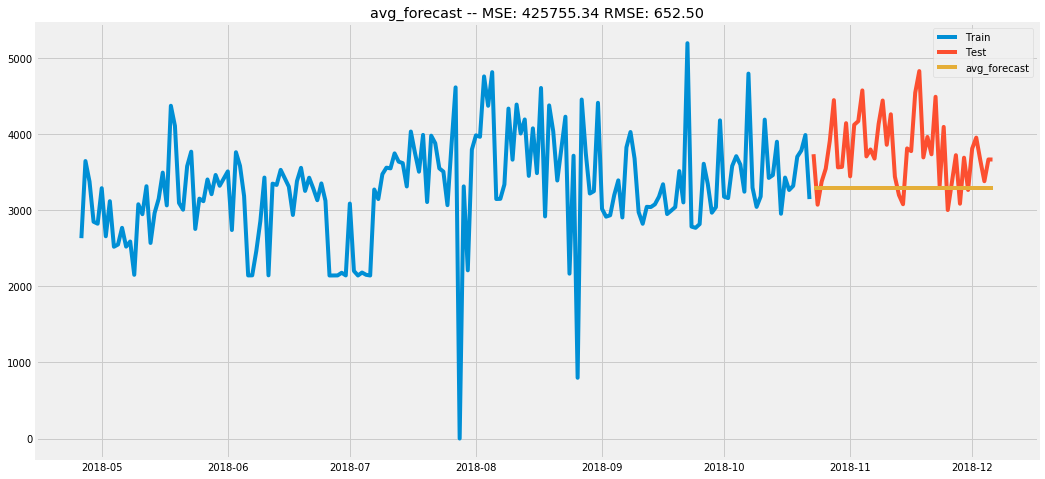

In [40]:
plot_and_eval(yhat.avg_forecast, test)

## 3. Moving Average

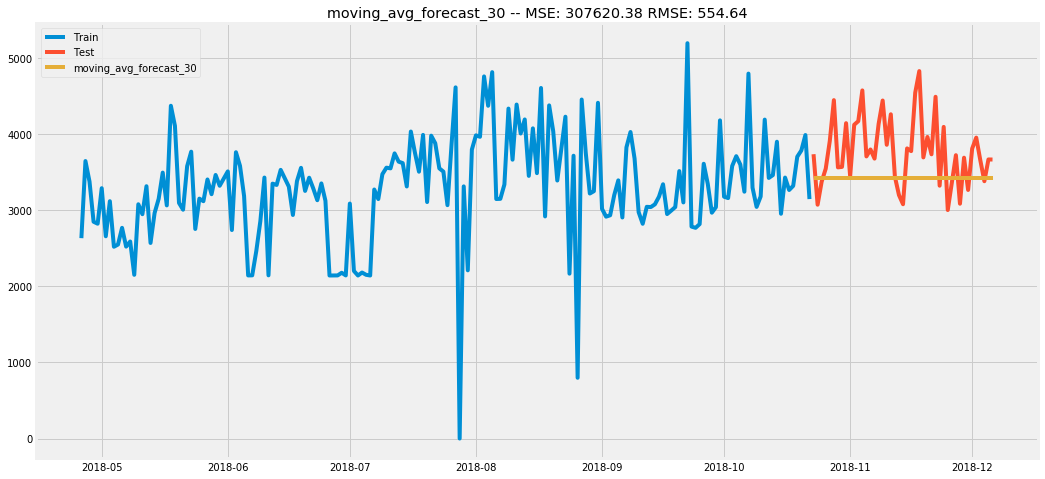

In [41]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]
plot_and_eval(yhat.moving_avg_forecast_30, test)

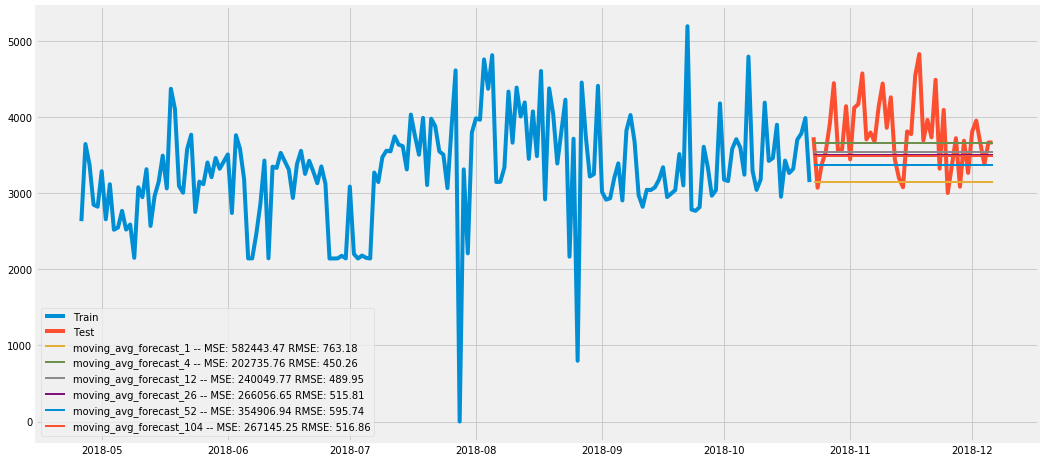

In [42]:
period_vals = [1, 4, 12, 26, 52, 104]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, test, linewidth=2)

## 4. Holt's Linear Trend Model

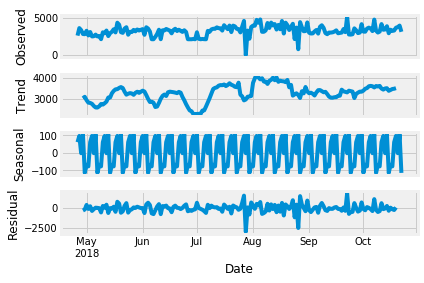

In [43]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

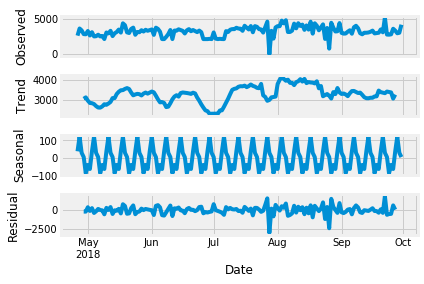

In [44]:
train = df[:'2018-09']['Calories Burned'].resample('D').agg('sum')
test = df['2018-10':]['Calories Burned'].resample('D').agg('sum')

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [45]:
# # TODO: Fix this cell (name 'holt' is not defined)

# Holt(train).fit(smoothing_level=.9, smoothing_slope=.1)

# yhat['holt_linear'] = holt.forecast(test.shape[0])
# test
# # plot_and_eval(y_hat.holt_linear)